In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch

os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK")

train_verbs = pd.read_csv("Datasets/EuroparlNutidsr_trainset_posNumbers.csv", sep=";")
pos_numbers = train_verbs["pos_numbers"].values
pos_numbers_torch = []
for pos_number in pos_numbers:
    lst = pos_number.split(" ")
    lst = [float(i) for i in lst]
    input_tensor = torch.tensor(lst, dtype=torch.float32)
    pos_numbers_torch.append(input_tensor)
pos_numbers_torch = torch.stack(pos_numbers_torch)

labels = train_verbs["label"].values
labels_torch = []

for label in labels:
    if label == "1":
        label_tensor = torch.tensor([0, 1], dtype=torch.float32)
        labels_torch.append(label_tensor)
    else: 
        label_tensor = torch.tensor([1, 0], dtype=torch.float32)
        labels_torch.append(label_tensor)

labels_torch = torch.stack(labels_torch)

X_train, X_val, y_train, y_val = train_test_split(pos_numbers_torch, labels_torch, test_size=0.2, random_state=1212)

print(pos_numbers_torch.shape, labels_torch.shape)

torch.Size([196743, 11]) torch.Size([196743, 2])


In [75]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(11, 128),
            #nn.Linear(128, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 2),
            nn.ReLU()
        )   

    def forward(self, x):
        return self.layers(x)

model = SimpleNN()

In [76]:
device = "cpu"
torch.device(device)

model.train()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

for p in model.parameters():
    p.requires_grad = True

print(sum(p.nelement() for p in model.parameters()))

9922


In [77]:
from tqdm import tqdm

training_losses = []
eval_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    training_loss = 0.0
    eval_loss = 0.0
    
    model.train()

    for i in tqdm(range(len(X_train))):
        inputs = X_train[i]
        labels = y_train[i]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10000 == 0:
            print(loss.item())
        
        training_loss += loss.item()
    
    training_loss /= len(X_train)
    
    model.eval()

    for inputs, labels in zip(X_val, y_val):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    training_losses.append(training_loss)
    eval_losses.append(eval_loss)


Epoch 1


  0%|          | 131/157394 [00:00<02:00, 1307.94it/s]

1.5431671142578125


  7%|▋         | 10263/157394 [00:05<01:15, 1957.38it/s]

0.3465735912322998


 13%|█▎        | 20346/157394 [00:10<01:09, 1963.95it/s]

0.3465735912322998


 19%|█▉        | 30260/157394 [00:15<01:09, 1836.85it/s]

0.3465735912322998


 26%|██▌       | 40253/157394 [00:20<00:59, 1971.29it/s]

0.3465735912322998


 32%|███▏      | 50253/157394 [00:25<00:54, 1980.53it/s]

0.3465735912322998


 38%|███▊      | 60210/157394 [00:31<00:48, 1986.04it/s]

0.3465735912322998


 45%|████▍     | 70383/157394 [00:36<00:43, 1993.49it/s]

0.3465735912322998


 51%|█████     | 80369/157394 [00:41<00:39, 1951.97it/s]

0.3465735912322998


 57%|█████▋    | 90336/157394 [00:46<00:33, 1994.35it/s]

0.3465735912322998


 64%|██████▍   | 100359/157394 [00:51<00:28, 2001.37it/s]

0.3465735912322998


 70%|███████   | 110326/157394 [00:56<00:24, 1920.13it/s]

0.3465735912322998


 76%|███████▋  | 120262/157394 [01:01<00:19, 1939.25it/s]

0.3465735912322998


 83%|████████▎ | 130244/157394 [01:06<00:13, 1994.34it/s]

0.3465735912322998


 89%|████████▉ | 140262/157394 [01:11<00:08, 1938.70it/s]

0.3465735912322998


 96%|█████████▌| 150344/157394 [01:16<00:03, 1983.53it/s]

0.3465735912322998


100%|██████████| 157394/157394 [01:20<00:00, 1961.01it/s]


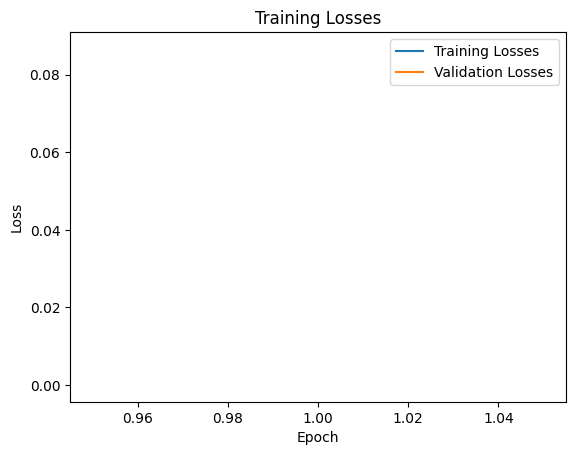

In [78]:
import matplotlib.pyplot as plt

epochs = range(1, len(training_losses) + 1)

plt.plot(epochs, [value/len(X_train) for value in training_losses], label='Training Losses')
plt.plot(epochs, eval_losses, label='Validation Losses')

plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()